This notebook calculates dispersion for two ion species plasma with streaming and electron pressure based upon Lyon et al. 2024 doi:.

Theta, $\theta$, is the propagation along zero-th order field. In these calculations velocities are normalized in terms of $V_a$ and all frequencies are normalized in in terms of $|k|V_a$.

Input paramters for the calculation of the dispersion curves are:

* M1,M2 are the Alfven Mach numbers of the plasma sound speeds
* Mv is the $\frac{| u_1 - u_2 |}{V_a}$
    * $u_1$, $u_2$ are zero-th order parallel flow speeds
    * Calculation is in center of momentum frame, where $\rho_1 u_1 = - \rho_2 u_2$
* Me is the Alven Mach Number of the sound speeed supported by the electron
* P = $\sqrt{(\frac{\gamma P_e}{\rho_{total}})}$ is the electron plasma pressure
* m is mass fraction in species 1
* f is charge fraction in species 1  
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from fractions import Fraction as frac

First we create a helper function that will assit with labeling the axis as a fraction of $\pi$

In [2]:
def pi_axis_formatter(val, pos, denomlim=10, pi=r'\pi'):
    """
    format label properly
    for example: 0.6666 pi --> 2π/3
               : 0      pi --> 0
               : 0.50   pi --> π/2  
    """
    minus = "-" if val < 0 else ""
    val = abs(val)
    ratio = frac(val/np.pi).limit_denominator(denomlim)
    n, d = ratio.numerator, ratio.denominator
    
    fmt2 = "%s" % d 
    if n == 0:
        fmt1 = "0"
    elif n == 1:
        fmt1 = pi
    else:
        fmt1 = r"%s%s" % (n,pi)
        
    fmtstring = "$" + minus + (fmt1 if d == 1 else r"{%s}/{%s}" % (fmt1, fmt2)) + "$"
    
    return fmtstring



These next functions calculate the dispersion curves the specified parameters as function of propagation angle along the zeroth order magnetic field.

In [4]:
def PropagationAngleDispersion(m,f,M1,M2,Mv,Me,num=101):
    """
    Calculate dispersion curves for multifluid systems.

    Parameters:
    m (float): mass fraction in species 1.
    f (float): charge fraction in species 1.
    M1 (float): Alfven Mach of species 1.
    M2 (float): Alfven Mach of species 2.
    Mv (float): Alfven Mach number of parallel flow speeds.
    Me (float): Alven Mach Number of the sound speeed supported by the electron.
    num (int, optional): Number of points in the propagation angle grid. Default is 101.

    Returns:
    tuple: A tuple containing:
        - theta (ndarray): Array of propagation angles.
        - nroots (ndarray): Number of roots for each propagation angle.
        - proots (ndarray): Roots of the dispersion polynomial for each propagation angle.
        - rcurve (ndarray): Real part of the dispersion curve for each propagation angle.
        - icurve (ndarray): Imaginary part of the dispersion curve for each propagation angle.

    This function calculates dispersion properties for multifluid systems over a range of propagation angles.
    It iterates through the propagation angle grid, computes dispersion coefficients, and extracts roots,
    real and imaginary parts of the dispersion curves for each angle.
    """
    theta = np.linspace(0.,np.pi/2,num)
    proots = np.zeros([6,num],dtype=np.cdouble)
    rcurve = np.zeros([6,num])
    icurve = np.zeros([6,num])
    nroots = np.zeros(num,dtype=int)
    for i in range (num):
        data = dispCoef(m,f,theta[i],M1,M2,Mv,Me)
        polly = np.poly1d(data)
        polroots = polly.r
        a = sorted(polroots)
        areal = np.real(a)
        aimag = np.imag(a)
        nroots[i] = int(np.asarray(areal.shape)[0])
        for j in range(nroots[i]):
            proots[j,i]  = polroots[j]
            rcurve[j,i]  = areal[j]
            icurve[j,i]  = aimag[j]
    return (theta,nroots,proots,rcurve,icurve)
    

In [5]:
def dispCoef(m,f,t,M1,M2,Mv,Me):
    """
    Calculate dispersion coefficients for a given set of parameters.

    Parameters:
    m (float): mass fraction in species 1.
    f (float): charge fraction in species 1.
    t (float): Propagation angle.
    M1 (float): Alfven Mach of species 1.
    M2 (float): Alfven Mach of species 2.
    Mv (float): Alfven Mach number of parallel flow speeds.
    Me (float): Alven Mach Number of the sound speeed supported by the electron.

    Returns:
    ndarray: Array containing the dispersion coefficients.

    This function calculates dispersion coefficients for a given set of parameters,
    including the mass ratio,chrage fraction, propagation angle, and Mach numbers
    of different wave components. It computes and returns an array containing these
    coefficients used in further calculations.
    """
    coeff_array = np.zeros(7) 
    cg0 = -m*(-1 + m)

    cg1 = 0.2e1*m*Mv*np.cos(t)*(2*m**2 - 3*m + 1)

    cg2 = ( M2**2*np.cos(t)**2*m**3 - Me**2*np.cos(t)**2*m**2 - M1**2*np.cos(t)**2*m**3 + M1**2*m**3 - M2**2*m**3
            - M1**2*m**2 + 0.2e1*M2**2*m**2 + Me**2*m**2 - M2**2*m - Me**2*m + 0.2e1*Me**2*np.cos(t)**2*f*m
            - M1**2*np.cos(t)**2*m + Mv**2*np.cos(t)**2*m - 0.5e1*Mv**2*np.cos(t)**2*m**4 + 0.10e2*Mv**2*np.cos(t)**2*m**3
             + 0.2e1*M1**2*np.cos(t)**2*m**2 - M2**2*np.cos(t)**2*m**2 - Me**2*np.cos(t)**2*f**2
              - 0.6e1*Mv**2*np.cos(t)**2*m**2 + m**2 - m )

    cg3 = (0.2e1*m*Mv*np.cos(t)*
           (0.2e1*M1**2*np.cos(t)**2*m**3 - 0.2e1*M2**2*np.cos(t)**2*m**3 - 0.4e1*M1**2*np.cos(t)**2*m**2 +
            0.4e1*M2**2*np.cos(t)**2*m**2 - 0.2e1*Me**2*np.cos(t)**2*f*m + 0.2e1*Me**2*np.cos(t)**2*m**2 +
           0.2e1*M1**2*np.cos(t)**2*m - 0.2e1*M1**2*m**3 - 0.2e1*M2**2*np.cos(t)**2*m + 0.2e1*M2**2*m**3 +
           0.2e1*np.cos(t)**2*Me**2*f - 0.2e1*Me**2*np.cos(t)**2*m + 0.3e1*M1**2*m**2 - 0.5e1*M2**2*m**2 -
           0.2e1*Me**2*m**2 - M1**2*m + 0.4e1*M2**2*m + 0.3e1*Me**2*m - M2**2 - Me**2 - 0.2e1*m**2 + 0.3e1*m - 0.1e1))

    cg4 = (-np.cos(t)**2*
           (-0.2e1*Me**2*Mv**2*np.cos(t)**2*f**2*m**2 + 0.2e1*Me**2*Mv**2*np.cos(t)**2*f**2*m +
             0.2e1*Me**2*Mv**2*np.cos(t)**2*f*m**2 - 0.2e1*Me**2*Mv**2*np.cos(t)**2*f*m - 0.6e1*M1**2*Mv**2*m**5
           + 0.6e1*M2**2*Mv**2*m**5 - 0.6e1*Me**2*Mv**2*m**4 + M1**2*Mv**2*m**2 - 0.5e1*Mv**4*np.cos(t)**2*m**6
           + 0.15e2*Mv**4*np.cos(t)**2*m**5 - 0.16e2*Mv**4*np.cos(t)**2*m**4 + 0.7e1*Mv**4*np.cos(t)**2*m**3 -
           Mv**4*np.cos(t)**2*m**2 - 0.6e1*Mv**2*m**4 + 0.12e2*Mv**2*m**3 + 0.2e1*Me**2*f*m + 0.6e1*M1**2*Mv**2*np.cos(t)**2*m**5
            - 0.6e1*M2**2*Mv**2*np.cos(t)**2*m**5 - 0.12e2*M1**2*Mv**2*np.cos(t)**2*m**4 + 0.18e2*M2**2*Mv**2*np.cos(t)**2*m**4
            + 0.6e1*Me**2*Mv**2*np.cos(t)**2*m**4 + 0.6e1*M1**2*Mv**2*np.cos(t)**2*m**3 - 0.18e2*M2**2*Mv**2*np.cos(t)**2*m**3
            - 0.12e2*Me**2*Mv**2*np.cos(t)**2*m**3 + 0.6e1*M2**2*Mv**2*np.cos(t)**2*m**2 + 0.6e1*Me**2*Mv**2*np.cos(t)**2*m**2
            + M1**2*m**2 + M2**2*m**2 - Me**2*m - M1**2*Me**2*f**2*m + M2**2*Me**2*f**2*m + 0.2e1*M1**2*Me**2*f*m -
           M1**2*M2**2*m - M1**2*Me**2*m + M2**2*Mv**2*m + Me**2*Mv**2*m + 0.12e2*M1**2*Mv**2*m**4 - 0.18e2*M2**2*Mv**2*m**4
            - 0.7e1*M1**2*Mv**2*m**3 + 0.19e2*M2**2*Mv**2*m**3 + 0.12e2*Me**2*Mv**2*m**3 + M1**2*M2**2*m**2
            - M2**2*Me**2*f**2 - 0.8e1*M2**2*Mv**2*m**2 - 0.7e1*Me**2*Mv**2*m**2 - M1**2*m - 0.7e1*m**2*Mv**2
            - M2**2*m + m*Mv**2 - Me**2*f**2))

    cg5 = (0.2e1*Mv*np.cos(t)**3*m*
           (0.2e1*Me**2*Mv**2*np.cos(t)**2*f*m**3 - 0.4e1*Me**2*Mv**2*np.cos(t)**2*f*m**2 + 0.2e1*Me**2*Mv**2*np.cos(t)**2*f*m
             - 0.2e1*M1**2*Mv**2*m**5 + 0.2e1*M2**2*Mv**2*m**5 - 0.2e1*Me**2*Mv**2*m**4 + M1**2*Mv**2*m**2
            - 0.2e1*Mv**4*np.cos(t)**2*m**6 + 0.7e1*Mv**4*np.cos(t)**2*m**5 - 0.9e1*Mv**4*np.cos(t)**2*m**4
            + 0.5e1*Mv**4*np.cos(t)**2*m**3 - Mv**4*np.cos(t)**2*m**2 - 0.2e1*Mv**2*m**4 + 0.5e1*Mv**2*m**3
            + 0.2e1*Me**2*f*m - 0.2e1*M2**2*Mv**2*np.cos(t)**2*m - 0.2e1*Me**2*Mv**2*np.cos(t)**2*m
            + 0.2e1*M1**2*Mv**2*np.cos(t)**2*m**5 - 0.2e1*M2**2*Mv**2*np.cos(t)**2*m**5 - 0.4e1*M1**2*Mv**2*np.cos(t)**2*m**4
            + 0.8e1*M2**2*Mv**2*np.cos(t)**2*m**4 + 0.2e1*Me**2*Mv**2*np.cos(t)**2*m**4 + 0.2e1*M1**2*Mv**2*np.cos(t)**2*m**3
            - 0.12e2*M2**2*Mv**2*np.cos(t)**2*m**3 - 0.6e1*Me**2*Mv**2*np.cos(t)**2*m**3 + 0.8e1*M2**2*Mv**2*np.cos(t)**2*m**2
            + 0.6e1*Me**2*Mv**2*np.cos(t)**2*m**2 + M1**2*m**2 + M2**2*m**2 - Me**2*m + M2**2*Mv**2*m + Me**2*Mv**2*m
            + 0.5e1*M1**2*Mv**2*m**4 - 0.7e1*M2**2*Mv**2*m**4 - 0.4e1*M1**2*Mv**2*m**3 + 0.9e1*M2**2*Mv**2*m**3
            + 0.5e1*Me**2*Mv**2*m**3 - 0.5e1*M2**2*Mv**2*m**2 - 0.4e1*Me**2*Mv**2*m**2 - M1**2*m - 0.4e1*m**2*Mv**2
            - 0.2e1*M2**2*m + m*Mv**2 + M2**2 + Me**2 - 0.2e1*Me**2*f))

    cg6 = ( np.cos(t)**4*
            (M1**2*M2**2*Mv**2*m**4 - 2*M1**2*M2**2*Mv**2*m**3 - M1**2*Me**2*Mv**2*m**3 + M1**2*M2**2*Mv**2*m**2
              + M1**2*Me**2*Mv**2*m**2 - Me**2*Mv**2*f**2*m**2 - 2*Me**2*Mv**2*f*m**3 + Me**2*Mv**2*f**2*m
             + 4*Me**2*Mv**2*f*m**2 - 2*Me**2*Mv**2*f*m - M1**2*Mv**4*np.cos(t)**2*m**7 + M2**2*Mv**4*np.cos(t)**2*m**7
             + 0.2e1*M1**2*Mv**4*np.cos(t)**2*m**6 - 0.5e1*M2**2*Mv**4*np.cos(t)**2*m**6 - Me**2*Mv**4*np.cos(t)**2*m**6
             - M1**2*Mv**4*np.cos(t)**2*m**5 + 0.10e2*M2**2*Mv**4*np.cos(t)**2*m**5 + 0.4e1*Me**2*Mv**4*np.cos(t)**2*m**5
             - 0.10e2*M2**2*Mv**4*np.cos(t)**2*m**4 - 0.6e1*Me**2*Mv**4*np.cos(t)**2*m**4 + 0.5e1*M2**2*Mv**4*np.cos(t)**2*m**3
             + 0.4e1*Me**2*Mv**4*np.cos(t)**2*m**3 - M2**2*Mv**4*np.cos(t)**2*m**2 - Me**2*Mv**4*np.cos(t)**2*m**2
             + M1**2*Mv**4*m**7 - M2**2*Mv**4*m**7 - 3*M1**2*Mv**4*m**6 + 4*M2**2*Mv**4*m**6 + Me**2*Mv**4*m**6
             + 3*M1**2*Mv**4*m**5 - 6*M2**2*Mv**4*m**5 - 3*Me**2*Mv**4*m**5 - M1**2*Mv**4*m**4 + 4*M2**2*Mv**4*m**4
             + 3*Me**2*Mv**4*m**4 - M2**2*Mv**4*m**3 - Me**2*Mv**4*m**3 + Mv**6*np.cos(t)**2*m**8 - 0.4e1*Mv**6*np.cos(t)**2*m**7
             + 0.6e1*Mv**6*np.cos(t)**2*m**6 - 0.4e1*Mv**6*np.cos(t)**2*m**5 + Mv**6*np.cos(t)**2*m**4 + Mv**4*m**6 - 3*Mv**4*m**5
             + 3*Mv**4*m**4 - Mv**4*m**3 - M1**2*Me**2*f**2*m + M2**2*Me**2*f**2*m + 2*M1**2*Me**2*f*m - M1**2*M2**2*m
             - M1**2*Me**2*m + M2**2*Mv**2*m + Me**2*Mv**2*m - M1**2*Mv**2*m**4 - M2**2*Mv**2*m**4 + M1**2*Mv**2*m**3
             + 3*M2**2*Mv**2*m**3 + Me**2*Mv**2*m**3 + M1**2*M2**2*m**2 - M2**2*Me**2*f**2 - 3*M2**2*Mv**2*m**2
             - 2*Me**2*Mv**2*m**2 + M2**2*Me**2*Mv**2*f**2*m**3 + M1**2*Me**2*Mv**2*f**2*m**2 + 2*M1**2*Me**2*Mv**2*f*m**3
             - 2*M2**2*Me**2*Mv**2*f**2*m**2 - 2*M1**2*Me**2*Mv**2*f*m**2 + M2**2*Me**2*Mv**2*f**2*m
             - Me**2*Mv**4*np.cos(t)**2*f**2*m**4 - 0.2e1*Me**2*Mv**4*np.cos(t)**2*f*m**5 + 0.2e1*Me**2*Mv**4*np.cos(t)**2*f**2*m**3
             + 0.6e1*Me**2*Mv**4*np.cos(t)**2*f*m**4 - Me**2*Mv**4*np.cos(t)**2*f**2*m**2 - 0.6e1*Me**2*Mv**4*np.cos(t)**2*f*m**3
             + 0.2e1*Me**2*Mv**4*np.cos(t)**2*f*m**2 - M1**2*Me**2*Mv**2*f**2*m**3))
        
    coeff_array[0] = cg0
    coeff_array[1] = cg1
    coeff_array[2] = cg2
    coeff_array[3] = cg3
    coeff_array[4] = cg4
    coeff_array[5] = cg5
    coeff_array[6] = cg6

    return coeff_array

And finally we have functions to plot the dispersion curves.  Each root is plotted with a different color.

In [6]:
def PlotCurves(ax,theta,rcurve,icurve,linetype = '-'):
    """
    Plot curves with real and imaginary parts.

    Parameters:
    ax (Axes): The axes on which to plot the curves.
    theta (ndarray): Array of propagation angles.
    rcurve (ndarray): Array of real parts of the curves.
    icurve (ndarray): Array of imaginary parts of the curves.
    linetype (str, optional): The linestyle for the plot. Defaults to '-'.

    Returns:
    ax ojbect is modifed during this function call.

    This function plots curves with real and imaginary parts on the provided axes.
    It takes arrays of propagation angles, real parts of the curves, and imaginary
    parts of the curves, along with an optional linestyle. The function then plots
    these curves on the specified axes.
    """
    colors = ['tab:red','tab:blue','tab:cyan','tab:olive','tab:orange','tab:purple']

    sizeroots = np.max(np.sqrt(rcurve**2 + icurve**2))
    displace = 0.01*sizeroots
    nline = int(rcurve.shape[0])
    npt = int(rcurve.shape[1])
    disp = np.zeros([nline,npt])
    for i in range(npt):
        for j in range(nline):
            if ( abs(icurve[j,i]) > 1.e-6 and abs(rcurve[j,i]-rcurve[j-1,i]) <1.e-6):
                disp[j,i] = displace
                disp[j-1,i] = -displace
    thetbuf = np.zeros(npt)
    linbuf = np.zeros(npt)
    #   plot over lines
    wid=2
    thresh = 0.01
    for i in range(nline):
        # plot real part
        nz = abs(rcurve[i,:]) > 1.e-6
        nr = (abs(icurve[i,:]) > 1.e-6)
        nshow = ( abs(rcurve[i,:]) > thresh*abs(icurve[i,:]) )

        start = -1
        segment = False
        first = True
        flag = disp[i,0]
        newflag = flag
        for j in range(npt):
            # start a segment
            if ( nshow[j] == True and segment == False and first == True  ) :
                flag = disp[i,j]
                start = j
                segment = True
                first = False
            else:
                if ( nshow[j] == True and segment == True  ) :
                    newflag = disp[i,j]
                    if ( newflag != flag ):
                        if ( flag != 0 ):
                            wid = 4
                        else:
                            wid =2
                        ax.plot(theta[start:j+1],rcurve[i,start:j+1]+disp[i,start:j+1],colors[i],lw=wid,linestyle=linetype)
                        segment = False
                        start = j
                        flag = newflag
                elif( nshow[j] == True and segment == False   ) :
                    segment = True
                    newflag = disp[i,j]
                    if ( newflag != flag ):
                        if ( flag != 0 ):
                            wid = 4
                        else:
                            wid =2
                        ax.plot(theta[start:j],rcurve[i,start:j]+disp[i,start:j],colors[i],lw=wid,linestyle=linetype)
                        segment = True
                        start = j-1
                        flag = newflag
                    
            if (segment == True and j == npt-1 ):
                if ( flag != 0 ):
                    wid=4
                else:
                    wid =2
                ax.plot(theta[start:npt],rcurve[i,start:npt],colors[i],lw=wid,linestyle=linetype)
                    
        # plot imaginary part                
        start = -1
        segment = False
        for j in range(npt):
            nz0 = nz[j] and nr[j]
            if ( nz0 == True and segment == False ) :
                segment = True
                start = j
            if ( segment == True and nz0 == False ) :
                segment = False
                ax.plot(theta[start:j],icurve[i,start:j],colors[i],marker='+',markerfacecolor=colors[i],linestyle='')
            if (segment == True and j == npt-1 ):
                ax.plot(theta[start:npt],icurve[i,start:npt],colors[i],marker='+',markerfacecolor=colors[i],linestyle=' ') 
        start = -1
        
        segment = False
        for j in range(npt):
            nz0 = ( not nz[j]) and nr[j]
            if ( nz0 == True and segment == False ) :
                segment = True
                start = j
            if ( segment == True and nz0 == False ) :
                segment = False
                ax.plot(theta[start:j],icurve[i,start:j],colors[i],marker='|',markerfacecolor=colors[i],markersize=8)
            if (segment == True and j == npt-1 ):
                ax.plot(theta[start:npt],icurve[i,start:npt],colors[i],marker='|',markerfacecolor=colors[i],linestyle=" ")
    return

In [12]:
def Plot(m,f,M1,M2,Mv,Me):
    """
    Plot dispersion curves for multifluid systems.

    Parameters:
    m (float): mass fraction in species 1.
    f (float): charge fraction in species 1.
    M1 (float): Alfven Mach of species 1.
    M2 (float): Alfven Mach of species 2.
    Mv (float): Alfven Mach number of parallel flow speeds.
    Me (float): Alven Mach Number of the sound speeed supported by the electron.

    Returns:
    A figure containing the Dispersion curves

    This function calculates dispersion curves for multifluid systems based on the provided parameters.
    It calls PropagationAngleDispersion to calculate dispersion properties and PlotCurves to visualize them.

    """
    theta,nroots,polroots,rcurve,icurve = PropagationAngleDispersion(m,f,M1,M2,Mv,Me)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ticklen = np.pi/4
    ax.xaxis.set_major_formatter(FuncFormatter(pi_axis_formatter))
    ax.xaxis.set_major_locator(MultipleLocator(base=ticklen))
    subtitle = f'm={m},f={f},M1={M1},M2={M2},Mv={Mv},Me={Me}'
    ax.title.set_text('Multifluid Dispersion Relations\n'+subtitle)
    ax.set_ylabel('Normalized Wave Speed')
    PlotCurves(ax,theta,rcurve,icurve,linetype = '-')
    

Now we can use these functions to explore the paramters space of dispersion curves for two species plasmas

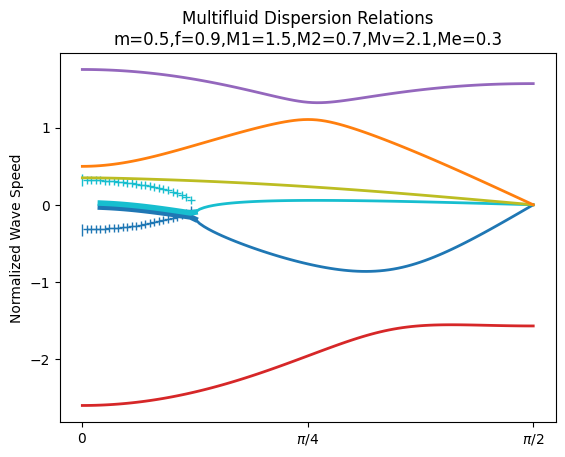

In [13]:
Plot(0.5,0.9,1.5,0.7,2.1,0.3)

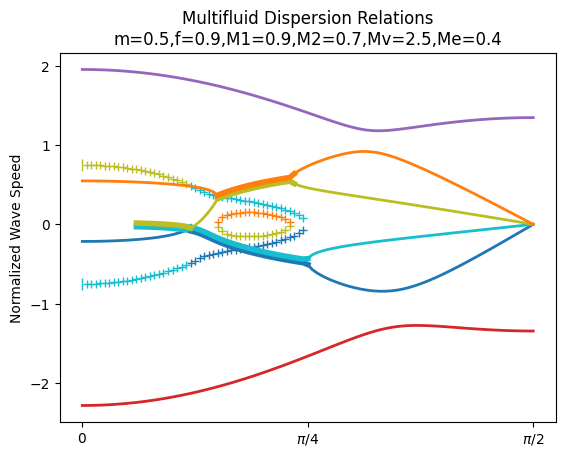

In [14]:
Plot(0.5,0.9,0.9,0.7,2.5,0.4)